# Opus-100 Dataset Exploration

This notebook explores the Opus-100 English-Spanish parallel corpus for neural machine translation.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import re

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Dataset

Load the parallel text files for training, development, and test sets.

In [75]:
data_dir = Path("../data/raw/opus-100")

# Load training data
with open(data_dir / "opus.en-es-train.en", "r", encoding="utf-8") as f:
    train_en = [line.strip() for line in f]

with open(data_dir / "opus.en-es-train.es", "r", encoding="utf-8") as f:
    train_es = [line.strip() for line in f]

# Load dev data
with open(data_dir / "opus.en-es-dev.en", "r", encoding="utf-8") as f:
    dev_en = [line.strip() for line in f]

with open(data_dir / "opus.en-es-dev.es", "r", encoding="utf-8") as f:
    dev_es = [line.strip() for line in f]

# Load test data
with open(data_dir / "opus.en-es-test.en", "r", encoding="utf-8") as f:
    test_en = [line.strip() for line in f]

with open(data_dir / "opus.en-es-test.es", "r", encoding="utf-8") as f:
    test_es = [line.strip() for line in f]

print(f"Data loaded successfully!")

Data loaded successfully!


## 2. Basic Statistics

Overview of dataset sizes and splits.

In [76]:
# Dataset size summary
total_pairs = len(train_en) + len(dev_en) + len(test_en)

print(f"Training:   {len(train_en):>10,} pairs ({len(train_en)/total_pairs*100:5.2f}%)")
print(f"Dev:        {len(dev_en):>10,} pairs ({len(dev_en)/total_pairs*100:5.2f}%)")
print(f"Test:       {len(test_en):>10,} pairs ({len(test_en)/total_pairs*100:5.2f}%)")
print(f"Total:      {total_pairs:>10,} pairs")

Training:    1,000,000 pairs (99.60%)
Dev:             2,000 pairs ( 0.20%)
Test:            2,000 pairs ( 0.20%)
Total:       1,004,000 pairs


## 3. Sentence Length Analysis

Analyze the distribution of sentence lengths and length ratios between languages.

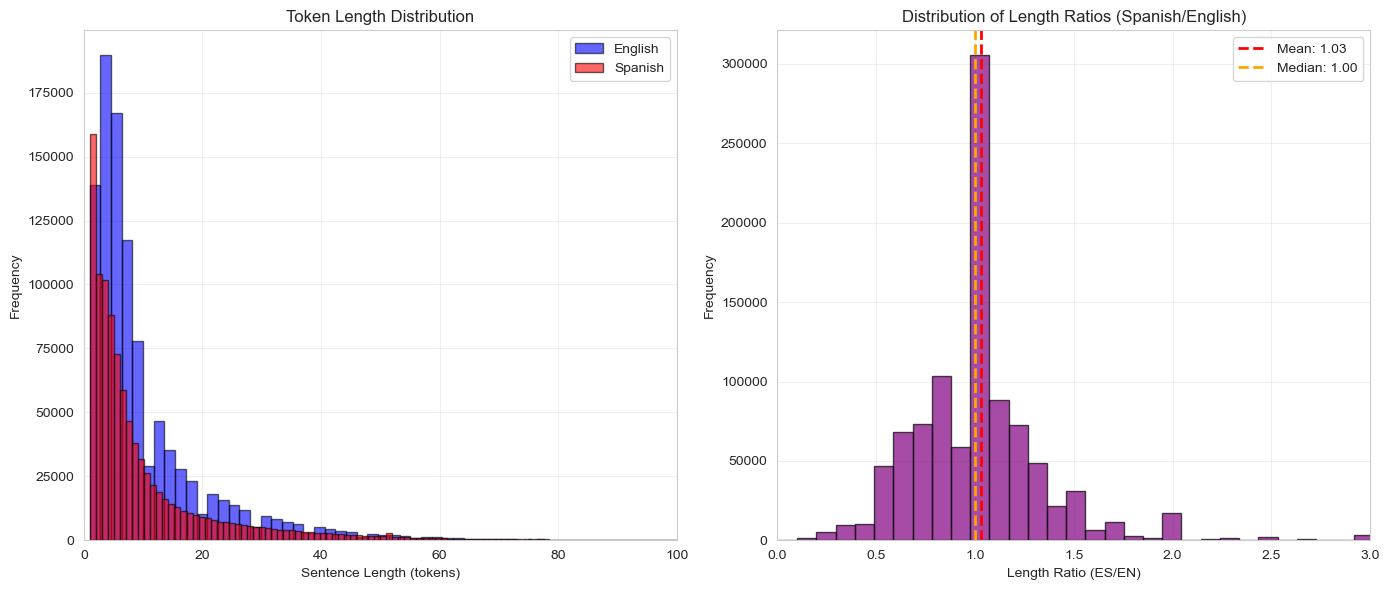

Spanish is 3.3% longer than English on average
Length correlation (EN vs ES): r=0.404


In [92]:
# Calculate sentence lengths (in tokens - simple whitespace split)
train_en_lengths = [len(sent.split()) for sent in train_en]
train_es_lengths = [len(sent.split()) for sent in train_es]

# Visualize token length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Token length distribution
axes[0].hist(train_en_lengths, bins=10000, alpha=0.6, label='English', color='blue', edgecolor='black')
axes[0].hist(train_es_lengths, bins=10000, alpha=0.6, label='Spanish', color='red', edgecolor='black')
axes[0].set_xlabel('Sentence Length (tokens)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Token Length Distribution')
axes[0].legend()
axes[0].set_xlim(0, 100)
axes[0].grid(True, alpha=0.3)

# Calculate and show length ratios
length_ratios = []
for en_len, es_len in zip(train_en_lengths, train_es_lengths):
    if en_len > 0:
        length_ratios.append(es_len / en_len)

# Calculate correlation
correlation = np.corrcoef(train_en_lengths, train_es_lengths)[0, 1]

# Length ratio histogram
axes[1].hist(length_ratios, bins=1000, edgecolor='black', alpha=0.7, color='purple')
axes[1].axvline(np.mean(length_ratios), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(length_ratios):.2f}')
axes[1].axvline(np.median(length_ratios), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {np.median(length_ratios):.2f}')
axes[1].set_xlabel('Length Ratio (ES/EN)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Length Ratios (Spanish/English)')
axes[1].set_xlim(0, 3)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Spanish is {(np.mean(length_ratios)-1)*100:.1f}% longer than English on average")
print(f"Length correlation (EN vs ES): r={correlation:.3f}")

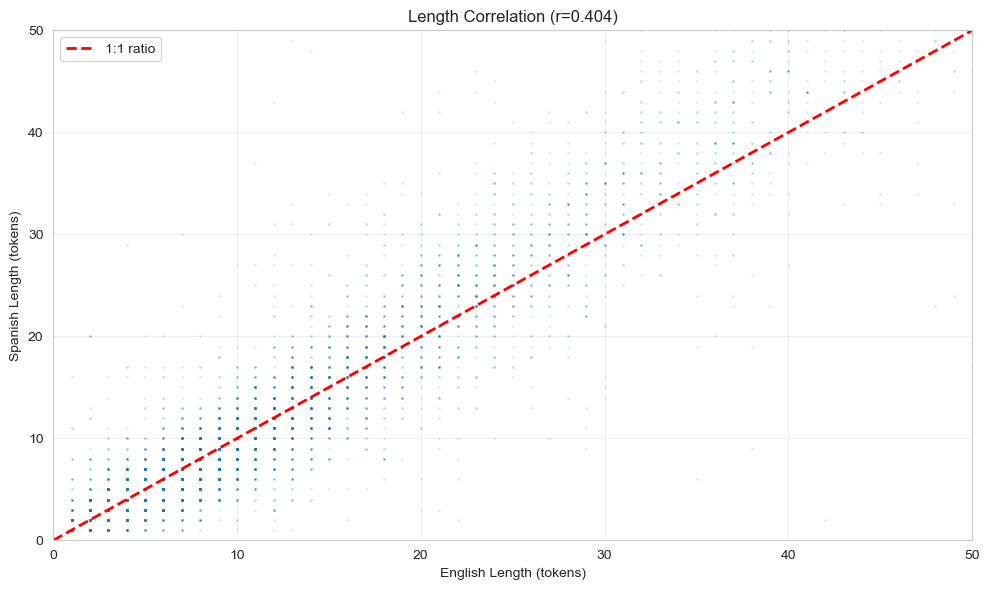

In [78]:
# Scatter plot: EN length vs ES length
sample_size = min(10000, len(train_en_lengths))
sample_indices = np.random.choice(len(train_en_lengths), sample_size, replace=False)
sample_en = [train_en_lengths[i] for i in sample_indices]
sample_es = [train_es_lengths[i] for i in sample_indices]

plt.figure(figsize=(10, 6))
plt.scatter(sample_en, sample_es, alpha=0.1, s=1)
plt.plot([0, 100], [0, 100], 'r--', linewidth=2, label='1:1 ratio')
plt.xlabel('English Length (tokens)')
plt.ylabel('Spanish Length (tokens)')
plt.title(f'Length Correlation (r={correlation:.3f})')
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Character-level Analysis

Analyze character-level statistics and special character usage.

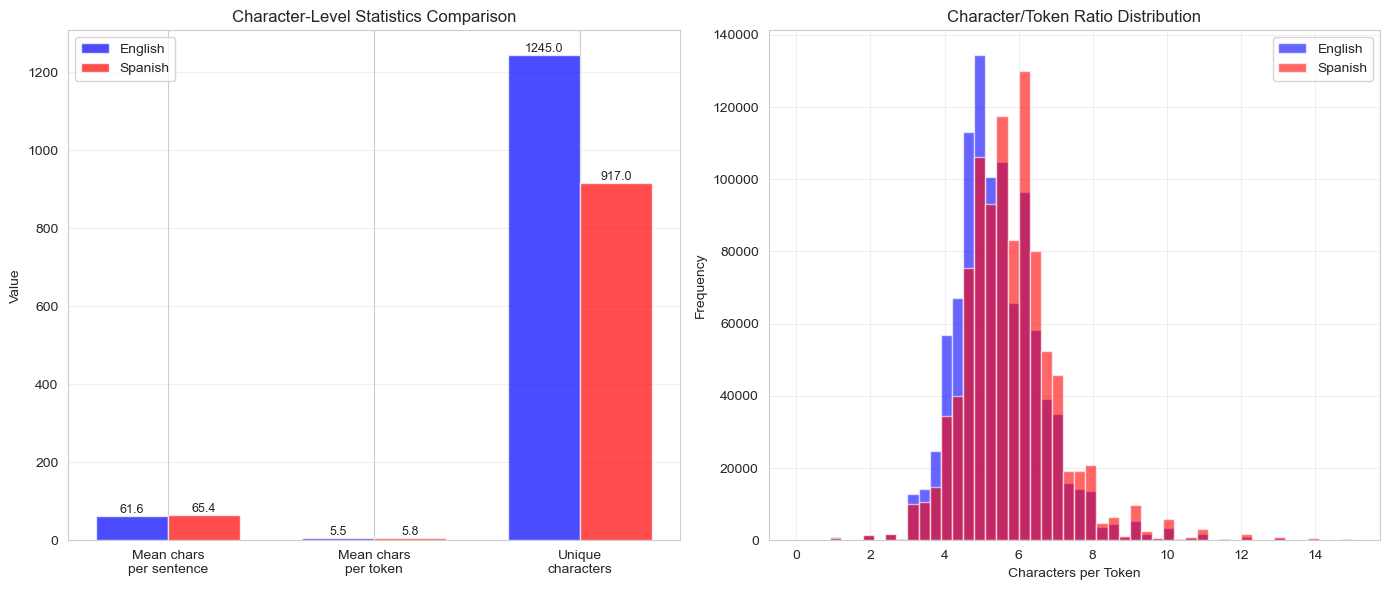

Spanish uses 122 unique characters not found in English


In [79]:
# Calculate character-level statistics
train_en_char_lengths = [len(sent) for sent in train_en]
train_es_char_lengths = [len(sent) for sent in train_es]

# Character per token ratio
en_char_per_token = [c/t if t > 0 else 0 for c, t in zip(train_en_char_lengths, train_en_lengths)]
es_char_per_token = [c/t if t > 0 else 0 for c, t in zip(train_es_char_lengths, train_es_lengths)]

# Build character sets
en_charset = set(''.join(train_en))
es_charset = set(''.join(train_es))

# Visualize character-level comparisons
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart comparison
metrics = ['Mean chars\nper sentence', 'Mean chars\nper token', 'Unique\ncharacters']
en_values = [np.mean(train_en_char_lengths), np.mean(en_char_per_token), len(en_charset)]
es_values = [np.mean(train_es_char_lengths), np.mean(es_char_per_token), len(es_charset)]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, en_values, width, label='English', color='blue', alpha=0.7)
axes[0].bar(x + width/2, es_values, width, label='Spanish', color='red', alpha=0.7)
axes[0].set_ylabel('Value')
axes[0].set_title('Character-Level Statistics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (ev, sv) in enumerate(zip(en_values, es_values)):
    axes[0].text(i - width/2, ev, f'{ev:.1f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, sv, f'{sv:.1f}', ha='center', va='bottom', fontsize=9)

# Chars per token distribution
axes[1].hist(en_char_per_token, bins=50, alpha=0.6, label='English', color='blue', range=(0, 15))
axes[1].hist(es_char_per_token, bins=50, alpha=0.6, label='Spanish', color='red', range=(0, 15))
axes[1].set_xlabel('Characters per Token')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Character/Token Ratio Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Spanish uses {len(es_charset - en_charset)} unique characters not found in English")

In [80]:
# Analyze special characters
import string

def count_special_chars(sentences):
    """Count frequency of punctuation and special characters."""
    char_counts = Counter(''.join(sentences))
    return char_counts

es_chars = count_special_chars(train_es)

# Spanish-specific characters
spanish_special = {'á', 'é', 'í', 'ó', 'ú', 'ñ', 'ü', 'Á', 'É', 'Í', 'Ó', 'Ú', 'Ñ', 'Ü', '¡', '¿'}
es_special_counts = {char: es_chars.get(char, 0) for char in spanish_special if es_chars.get(char, 0) > 0}

print("Spanish-specific Characters:")
print("-" * 40)
for char, count in sorted(es_special_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"'{char}': {count:>12,}")

Spanish-specific Characters:
----------------------------------------
'ó':      384,469
'í':      306,723
'á':      241,397
'é':      196,505
'¿':      136,735
'ñ':       77,183
'ú':       62,947
'¡':       51,606
'É':        5,125
'Á':        3,035
'Ó':        1,954
'ü':        1,625
'Í':          928
'Ú':          476
'Ñ':          258
'Ü':           35


## 5. Vocabulary Analysis

Analyze vocabulary size, word frequency distributions, and rare words.

In [81]:
# Build vocabulary
def build_vocab(sentences):
    """Build vocabulary from list of sentences."""
    all_words = []
    for sent in sentences:
        all_words.extend(sent.lower().split())
    return Counter(all_words)

vocab_en = build_vocab(train_en)
vocab_es = build_vocab(train_es)

print(f"English vocabulary size: {len(vocab_en):,}")
print(f"Spanish vocabulary size: {len(vocab_es):,}")
print(f"\nTotal English tokens: {sum(vocab_en.values()):,}")
print(f"Total Spanish tokens: {sum(vocab_es.values()):,}")

print("\n" + "="*50)
print("\nMost common English words:")
for word, count in vocab_en.most_common(20):
    print(f"  {word:20s} {count:8,}")

print("\n" + "="*50)
print("\nMost common Spanish words:")
for word, count in vocab_es.most_common(20):
    print(f"  {word:20s} {count:8,}")

English vocabulary size: 435,944
Spanish vocabulary size: 522,299

Total English tokens: 10,753,217
Total Spanish tokens: 11,076,716


Most common English words:
  the                   621,140
  of                    322,781
  to                    285,759
  and                   259,268
  a                     190,889
  in                    189,538
  you                   156,204
  i                     147,828
  is                    105,154
  that                  104,059
  for                   100,175
  -                      94,341
  on                     75,932
  it                     70,211
  with                   67,012
  be                     64,603
  this                   61,923
  are                    54,554
  have                   52,214
  we                     51,600


Most common Spanish words:
  de                    694,795
  la                    391,801
  que                   290,509
  el                    272,990
  en                    265,986
  y      

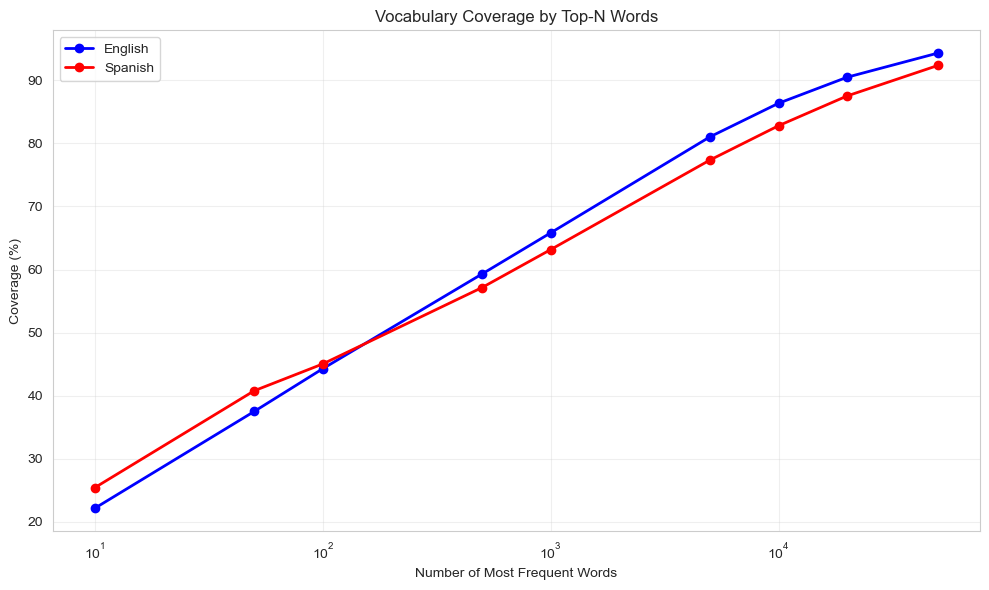

In [82]:
# Vocabulary coverage analysis
def vocab_coverage(vocab, n_words):
    """Calculate what percentage of tokens are covered by top N words."""
    total_tokens = sum(vocab.values())
    top_n_tokens = sum(count for word, count in vocab.most_common(n_words))
    return (top_n_tokens / total_tokens) * 100

coverage_points = [10, 50, 100, 500, 1000, 5000, 10000, 20000, 50000]

en_coverage = [vocab_coverage(vocab_en, n) for n in coverage_points]
es_coverage = [vocab_coverage(vocab_es, n) for n in coverage_points]

# Plot coverage
plt.figure(figsize=(10, 6))
plt.plot(coverage_points, en_coverage, 'b-o', label='English', linewidth=2)
plt.plot(coverage_points, es_coverage, 'r-o', label='Spanish', linewidth=2)
plt.xlabel('Number of Most Frequent Words')
plt.ylabel('Coverage (%)')
plt.title('Vocabulary Coverage by Top-N Words')
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
### Rare Word Analysis

# Analyze frequency distribution
def analyze_rare_words(vocab):
    """Analyze singleton and rare word statistics."""
    freq_dist = Counter([count for count in vocab.values()])
    
    singletons = sum(1 for count in vocab.values() if count == 1)
    doubletons = sum(1 for count in vocab.values() if count == 2)
    rare_1_5 = sum(1 for count in vocab.values() if 1 <= count <= 5)
    rare_1_10 = sum(1 for count in vocab.values() if 1 <= count <= 10)
    
    return {
        'singletons': singletons,
        'doubletons': doubletons,
        'rare_1_5': rare_1_5,
        'rare_1_10': rare_1_10,
        'total_vocab': len(vocab),
        'freq_dist': freq_dist
    }

en_rare_stats = analyze_rare_words(vocab_en)
es_rare_stats = analyze_rare_words(vocab_es)

print(f"• Singletons: EN={en_rare_stats['singletons']:,} ({en_rare_stats['singletons']/len(vocab_en)*100:.1f}%), ES={es_rare_stats['singletons']:,} ({es_rare_stats['singletons']/len(vocab_es)*100:.1f}%)")
print(f"• Rare words (≤5): EN={en_rare_stats['rare_1_5']:,} ({en_rare_stats['rare_1_5']/len(vocab_en)*100:.1f}%), ES={es_rare_stats['rare_1_5']:,} ({es_rare_stats['rare_1_5']/len(vocab_es)*100:.1f}%)")

• Singletons: EN=281,033 (64.5%), ES=327,666 (62.7%)
• Rare words (≤5): EN=375,783 (86.2%), ES=447,262 (85.6%)


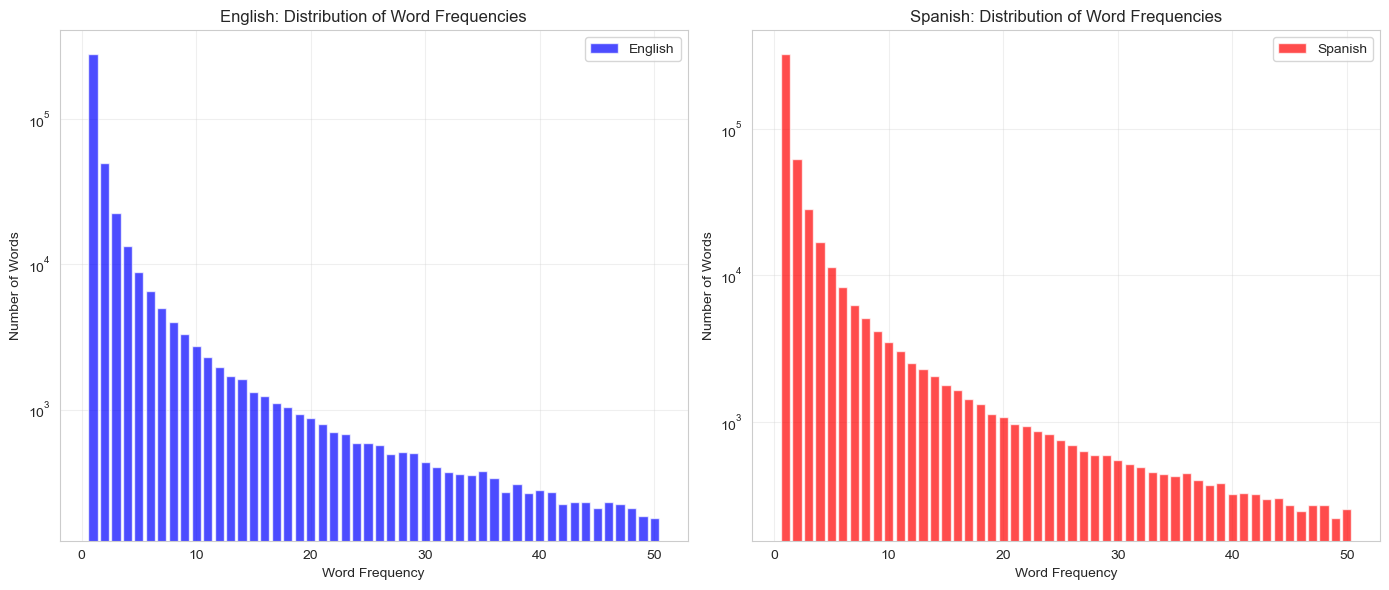

In [84]:
# Visualize frequency distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get frequency of frequencies (how many words appear X times)
en_freq_counts = sorted(en_rare_stats['freq_dist'].items())
es_freq_counts = sorted(es_rare_stats['freq_dist'].items())

# Plot up to frequency 50 for clarity
en_freq_x = [f for f, c in en_freq_counts if f <= 50]
en_freq_y = [c for f, c in en_freq_counts if f <= 50]
es_freq_x = [f for f, c in es_freq_counts if f <= 50]
es_freq_y = [c for f, c in es_freq_counts if f <= 50]

axes[0].bar(en_freq_x, en_freq_y, alpha=0.7, color='blue', label='English')
axes[0].set_xlabel('Word Frequency')
axes[0].set_ylabel('Number of Words')
axes[0].set_title('English: Distribution of Word Frequencies')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].bar(es_freq_x, es_freq_y, alpha=0.7, color='red', label='Spanish')
axes[1].set_xlabel('Word Frequency')
axes[1].set_ylabel('Number of Words')
axes[1].set_title('Spanish: Distribution of Word Frequencies')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Sample Examples

Display representative translation pairs from the training set.

In [85]:
# Display random examples (reduced from 30 to 10)
sample_indices = np.random.choice(len(train_en), size=10, replace=False)

print("Sample Translation Pairs:\n")
print("=" * 80)
for i, idx in enumerate(sample_indices, 1):
    en_len = len(train_en[idx].split())
    es_len = len(train_es[idx].split())
    ratio = es_len / en_len if en_len > 0 else 0
    
    print(f"\nExample {i} (EN: {en_len} tokens, ES: {es_len} tokens, ratio: {ratio:.2f}):")
    print(f"  EN: {train_en[idx]}")
    print(f"  ES: {train_es[idx]}")
print("\n" + "=" * 80)

Sample Translation Pairs:


Example 1 (EN: 3 tokens, ES: 2 tokens, ratio: 0.67):
  EN: Maciek, calm down!
  ES: ¡Tranquilo, Maciek!

Example 2 (EN: 1 tokens, ES: 1 tokens, ratio: 1.00):
  EN: Observations
  ES: Observaciones

Example 3 (EN: 3 tokens, ES: 2 tokens, ratio: 0.67):
  EN: I feel it.
  ES: Lo siento.

Example 4 (EN: 5 tokens, ES: 5 tokens, ratio: 1.00):
  EN: What I am right now.
  ES: Lo bien que estoy ahora.

Example 5 (EN: 5 tokens, ES: 5 tokens, ratio: 1.00):
  EN: He's a very lucky man.
  ES: Es un hombre muy afortunado.

Example 6 (EN: 1 tokens, ES: 1 tokens, ratio: 1.00):
  EN: Okay.
  ES: Bien.

Example 7 (EN: 25 tokens, ES: 39 tokens, ratio: 1.56):
  EN: Drug policy evaluations face considerable difficulties in their attempts to link the outputs of drug strategies or action plans with changes in the drug situation.
  ES: Gasto consignado y no consignado como relacionado con las drogas establecer una relación entre los resultados de las estrategias o planes de acción

## 7. Data Quality Issues

Check for potential issues that may affect model training.

In [86]:
# Check for empty sentences
empty_en = sum(1 for sent in train_en if len(sent.strip()) == 0)
empty_es = sum(1 for sent in train_es if len(sent.strip()) == 0)

print("Empty Sentences:")
print("=" * 60)
print(f"Empty English sentences: {empty_en}")
print(f"Empty Spanish sentences: {empty_es}")

# Check for very short sentences (< 3 tokens)
very_short_en = sum(1 for sent in train_en if len(sent.split()) < 3)
very_short_es = sum(1 for sent in train_es if len(sent.split()) < 3)

print(f"\nVery Short Sentences (< 3 tokens):")
print(f"English: {very_short_en:,} ({very_short_en/len(train_en)*100:.2f}%)")
print(f"Spanish: {very_short_es:,} ({very_short_es/len(train_es)*100:.2f}%)")

# Check for very long sentences (> 100 tokens)
very_long_en = sum(1 for sent in train_en if len(sent.split()) > 100)
very_long_es = sum(1 for sent in train_es if len(sent.split()) > 100)

print(f"\nVery Long Sentences (> 100 tokens):")
print(f"English: {very_long_en:,} ({very_long_en/len(train_en)*100:.2f}%)")
print(f"Spanish: {very_long_es:,} ({very_long_es/len(train_es)*100:.2f}%)")

# Duplicate analysis
print("\n" + "="*60)
print("DUPLICATE ANALYSIS")
print("="*60)

duplicate_en = len(train_en) - len(set(train_en))
duplicate_es = len(train_es) - len(set(train_es))

print(f"\nDuplicate source sentences:")
print(f"English: {duplicate_en:,} ({duplicate_en/len(train_en)*100:.2f}%)")
print(f"Spanish: {duplicate_es:,} ({duplicate_es/len(train_es)*100:.2f}%)")

# Check exact pair duplicates
pairs = list(zip(train_en, train_es))
unique_pairs = set(pairs)
pair_duplicates = len(pairs) - len(unique_pairs)

print(f"\nExact pair duplicates: {pair_duplicates:,} ({pair_duplicates/len(pairs)*100:.2f}%)")

# One-to-many mappings
from collections import defaultdict
en_to_es = defaultdict(set)
for en, es in pairs:
    en_to_es[en].add(es)

multiple_translations = {en: es_set for en, es_set in en_to_es.items() if len(es_set) > 1}
print(f"EN sentences with multiple ES translations: {len(multiple_translations):,}")

# Show most common duplicates
en_counts = Counter(train_en)
print(f"\nTop 10 most frequent EN sentences:")
for i, (en, count) in enumerate(en_counts.most_common(10), 1):
    en_display = en[:60] if len(en) <= 60 else en[:57] + "..."
    print(f"{i:2d}. [{count:4d}x] {en_display}")

Empty Sentences:
Empty English sentences: 0
Empty Spanish sentences: 0

Very Short Sentences (< 3 tokens):
English: 138,977 (13.90%)
Spanish: 159,005 (15.90%)

Very Long Sentences (> 100 tokens):
English: 1,062 (0.11%)
Spanish: 1,716 (0.17%)

DUPLICATE ANALYSIS

Duplicate source sentences:
English: 122,441 (12.24%)
Spanish: 124,021 (12.40%)

Exact pair duplicates: 70,318 (7.03%)
EN sentences with multiple ES translations: 20,967

Top 10 most frequent EN sentences:
 1. [2244x] No.
 2. [1891x] What?
 3. [1502x] Thank you.
 4. [1284x] Okay.
 5. [1021x] Come on.
 6. [ 722x] I'm sorry.
 7. [ 694x] All right.
 8. [ 686x] No!
 9. [ 615x] Hey.
10. [ 453x] Good.


In [87]:
# Check length mismatch (potential misalignment)
def check_length_mismatch(en_sents, es_sents, threshold=3.0):
    """Find pairs where length ratio is extreme (potential misalignment)."""
    mismatches = []
    for i, (en, es) in enumerate(zip(en_sents, es_sents)):
        en_len = len(en.split())
        es_len = len(es.split())
        if en_len > 0 and es_len > 0:
            ratio = max(en_len, es_len) / min(en_len, es_len)
            if ratio > threshold:
                mismatches.append((i, en_len, es_len, ratio))
    return mismatches

mismatches = check_length_mismatch(train_en, train_es, threshold=3.0)

print("\n" + "="*60)
print("POTENTIAL MISALIGNMENTS")
print("="*60)
print(f"\nPairs with length ratio > 3.0: {len(mismatches):,} ({len(mismatches)/len(train_en)*100:.2f}%)")
print("\nExamples of potential misalignments:")
for idx, en_len, es_len, ratio in mismatches[:5]:
    print(f"\nIndex {idx} (ratio: {ratio:.2f}):")
    print(f"  EN ({en_len} tokens): {train_en[idx][:80]}...")
    print(f"  ES ({es_len} tokens): {train_es[idx][:80]}...")


POTENTIAL MISALIGNMENTS

Pairs with length ratio > 3.0: 12,067 (1.21%)

Examples of potential misalignments:

Index 49 (ratio: 3.50):
  EN (7 tokens): - Oh, have fun scrubbing my boxers....
  ES (2 tokens): - ¿Qué?...

Index 109 (ratio: 4.00):
  EN (4 tokens): Thank you. Thank you....
  ES (1 tokens): Gracias...

Index 276 (ratio: 4.00):
  EN (4 tokens): - Who is it?...
  ES (1 tokens): ¿Quién?...

Index 286 (ratio: 5.00):
  EN (1 tokens): Thomas?...
  ES (5 tokens): - ¿Que protegería mi trabajo?...

Index 292 (ratio: 8.00):
  EN (8 tokens): We need to take some X rays, though....
  ES (1 tokens): Señor....


## 8. Train/Dev/Test Split Analysis

Verify that data splits have similar distributions for fair evaluation.

In [88]:
# Calculate lengths for all splits
dev_en_lengths = [len(sent.split()) for sent in dev_en]
dev_es_lengths = [len(sent.split()) for sent in dev_es]
test_en_lengths = [len(sent.split()) for sent in test_en]
test_es_lengths = [len(sent.split()) for sent in test_es]

# Calculate statistics
train_en_mean = np.mean(train_en_lengths)
dev_en_mean = np.mean(dev_en_lengths)
test_en_mean = np.mean(test_en_lengths)
train_es_mean = np.mean(train_es_lengths)
dev_es_mean = np.mean(dev_es_lengths)
test_es_mean = np.mean(test_es_lengths)

print("Distribution Mismatch:")
print(f"Dev/Test sets are ~{(dev_en_mean/train_en_mean - 1)*100:.0f}% longer than training set")
print(f"This may lead to slightly underestimated performance during evaluation")

Distribution Mismatch:
Dev/Test sets are ~18% longer than training set
This may lead to slightly underestimated performance during evaluation


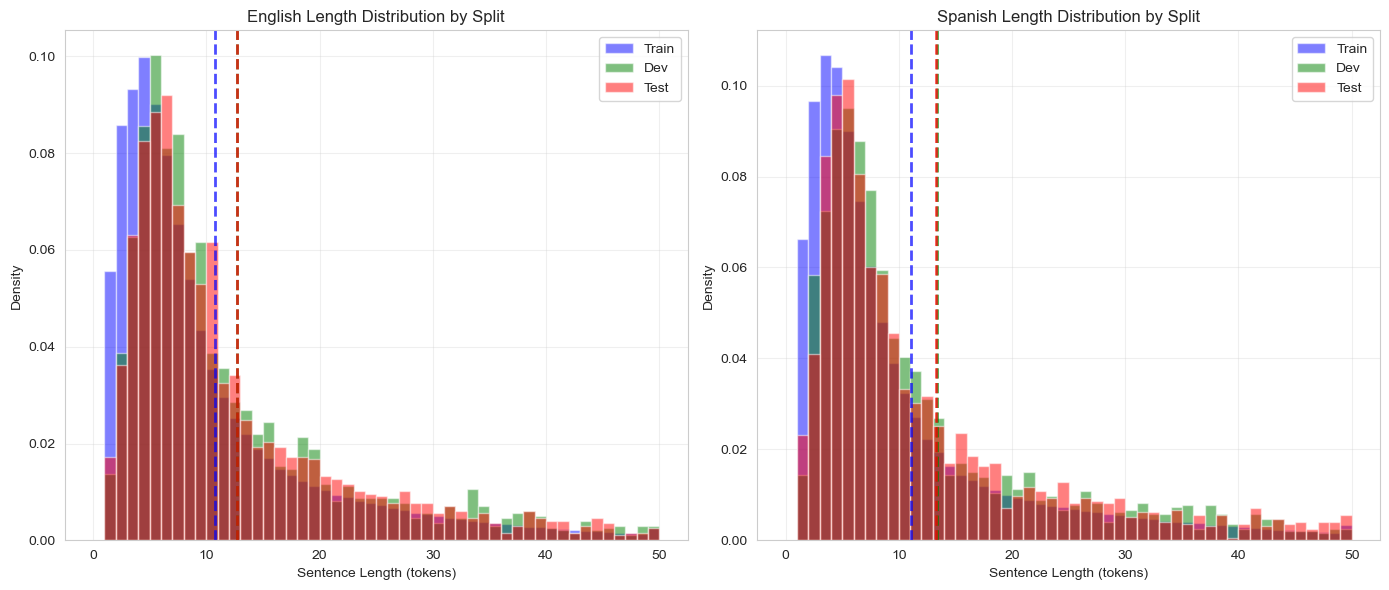

In [89]:
# Visualize distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# English comparison
axes[0].hist(train_en_lengths, bins=50, alpha=0.5, label='Train', color='blue', density=True, range=(0, 50))
axes[0].hist(dev_en_lengths, bins=50, alpha=0.5, label='Dev', color='green', density=True, range=(0, 50))
axes[0].hist(test_en_lengths, bins=50, alpha=0.5, label='Test', color='red', density=True, range=(0, 50))
axes[0].axvline(np.mean(train_en_lengths), color='blue', linestyle='--', linewidth=2, alpha=0.7)
axes[0].axvline(np.mean(dev_en_lengths), color='green', linestyle='--', linewidth=2, alpha=0.7)
axes[0].axvline(np.mean(test_en_lengths), color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Sentence Length (tokens)')
axes[0].set_ylabel('Density')
axes[0].set_title('English Length Distribution by Split')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spanish comparison
axes[1].hist(train_es_lengths, bins=50, alpha=0.5, label='Train', color='blue', density=True, range=(0, 50))
axes[1].hist(dev_es_lengths, bins=50, alpha=0.5, label='Dev', color='green', density=True, range=(0, 50))
axes[1].hist(test_es_lengths, bins=50, alpha=0.5, label='Test', color='red', density=True, range=(0, 50))
axes[1].axvline(np.mean(train_es_lengths), color='blue', linestyle='--', linewidth=2, alpha=0.7)
axes[1].axvline(np.mean(dev_es_lengths), color='green', linestyle='--', linewidth=2, alpha=0.7)
axes[1].axvline(np.mean(test_es_lengths), color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Sentence Length (tokens)')
axes[1].set_ylabel('Density')
axes[1].set_title('Spanish Length Distribution by Split')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Key Findings & Recommendations

Summary of important findings and actionable preprocessing recommendations.

In [119]:
print("=" * 80)
print(" " * 25 + "KEY FINDINGS SUMMARY")
print("=" * 80)

print("\n DATASET OVERVIEW:")
print(f"• Total pairs: {total_pairs:,} (Train: {len(train_en):,}, Dev: {len(dev_en):,}, Test: {len(test_en):,})")
print(f"• English vocab: {len(vocab_en):,} | Spanish vocab: {len(vocab_es):,} (+{len(vocab_es)-len(vocab_en):,} more)")
print(f"• Mean sentence length: EN={np.mean(train_en_lengths):.1f} tokens, ES={np.mean(train_es_lengths):.1f} tokens")
print(f"• Median sentence length: EN={np.median(train_en_lengths):.0f} tokens, ES={np.median(train_es_lengths):.0f} tokens")

print("\n LENGTH CHARACTERISTICS:")
print(f"• Length correlation: {correlation:.3f} (moderate correlation)")
print(f"• Spanish is {(np.mean(length_ratios)-1)*100:.1f}% longer than English on average")
print(f"• Mean ES/EN ratio: {np.mean(length_ratios):.3f}, Median: {np.median(length_ratios):.3f}")

print("\n CHARACTER-LEVEL:")
print(f"• Mean chars/token: EN={np.mean(en_char_per_token):.2f}, ES={np.mean(es_char_per_token):.2f}")
print(f"• Unique characters: EN={len(en_charset):,}, ES={len(es_charset):,}")
print(f"• Spanish uses {len(es_charset - en_charset)} unique characters not in English")
print(f"• Includes Spanish-specific accents: á, é, í, ó, ú, ñ, ¡, ¿")

print("\n VOCABULARY INSIGHTS:")
print(f"• Singletons: EN={en_rare_stats['singletons']:,} ({en_rare_stats['singletons']/len(vocab_en)*100:.1f}%), ES={es_rare_stats['singletons']:,} ({es_rare_stats['singletons']/len(vocab_es)*100:.1f}%)")
print(f"• Rare words (≤5): EN={en_rare_stats['rare_1_5']:,} ({en_rare_stats['rare_1_5']/len(vocab_en)*100:.1f}%), ES={es_rare_stats['rare_1_5']:,} ({es_rare_stats['rare_1_5']/len(vocab_es)*100:.1f}%)")
print(f"• Top 10K words cover ~{vocab_coverage(vocab_en, 10000):.1f}% of EN tokens")
print(f"• Most frequent words are stopwords (the, of, to, and, de, la, que, el)")

print("\n DATA QUALITY ISSUES:")
print(f"• Very short sentences (<3 tokens): {very_short_en:,} ({very_short_en/len(train_en)*100:.1f}%)")
print(f"• Very long sentences (>100 tokens): {very_long_en:,} ({very_long_en/len(train_en)*100:.1f}%)")
print(f"• Duplicate source sentences: {duplicate_en:,} ({duplicate_en/len(train_en)*100:.1f}%)")
print(f"• Exact pair duplicates: {pair_duplicates:,} ({pair_duplicates/len(pairs)*100:.1f}%)")
print(f"• One-to-many translations: {len(multiple_translations):,} EN sentences")
print(f"• Potential misalignments (ratio>3): {len(mismatches):,} ({len(mismatches)/len(train_en)*100:.2f}%)")
print(f"• Dev/Test are ~{(dev_en_mean/train_en_mean - 1)*100:.0f}% longer than Train")

print("\n" + "=" * 80)

                         KEY FINDINGS SUMMARY

 DATASET OVERVIEW:
• Total pairs: 1,004,000 (Train: 1,000,000, Dev: 2,000, Test: 2,000)
• English vocab: 435,944 | Spanish vocab: 522,299 (+86,355 more)
• Mean sentence length: EN=10.8 tokens, ES=11.1 tokens
• Median sentence length: EN=7 tokens, ES=6 tokens

 LENGTH CHARACTERISTICS:
• Length correlation: 0.404 (moderate correlation)
• Spanish is 3.3% longer than English on average
• Mean ES/EN ratio: 1.033, Median: 1.000

 CHARACTER-LEVEL:
• Mean chars/token: EN=5.50, ES=5.82
• Unique characters: EN=1,245, ES=917
• Spanish uses 122 unique characters not in English
• Includes Spanish-specific accents: á, é, í, ó, ú, ñ, ¡, ¿

 VOCABULARY INSIGHTS:
• Singletons: EN=281,033 (64.5%), ES=327,666 (62.7%)
• Rare words (≤5): EN=375,783 (86.2%), ES=447,262 (85.6%)
• Top 10K words cover ~86.4% of EN tokens
• Most frequent words are stopwords (the, of, to, and, de, la, que, el)

 DATA QUALITY ISSUES:
• Very short sentences (<3 tokens): 138,977 (13.9%